# Ameriflux and Earth Engine Joined EDA

Notebook to look at the EDA for Ameriflux and Earth Engine data

In [259]:
# import all relevant libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import re
import seaborn as sns
import datetime as dt
%matplotlib inline

Abbreviations:
* AF = Ameriflux 
* EE = Earth Engine

In [260]:
# Filter to get only the necessary sites
potential_sites_file = open('data/potential_sites.json')
potential_sites_dict = json.load(potential_sites_file)
potential_site_names = list(potential_sites_dict.keys())

all_sites_df = pd.read_csv("data/ameriflux_lulc_lat_long.csv")

wanted_site_and_info = all_sites_df[all_sites_df['SITE_ID'].isin(potential_site_names)]
# wanted_site_and_info.to_csv('data/wanted_sites.csv')

  SITE_ID   elevation
0  US-PFa  472.534573
1  US-Syv  540.559114
2  US-Bi1   -3.707723
3  US-Bi2   -5.102190
4  US-CS1  334.475391


(array([19.,  8.,  2.,  0.,  0.,  1.,  0.,  0.,  0.,  3.]),
 array([5.65676500e-02, 1.14686216e+01, 2.28806756e+01, 3.42927296e+01,
        4.57047835e+01, 5.71168375e+01, 6.85288915e+01, 7.99409455e+01,
        9.13529994e+01, 1.02765053e+02, 1.14177107e+02]),
 <BarContainer object of 10 artists>)

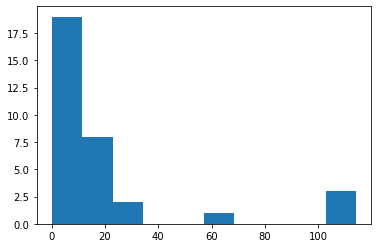

In [261]:
# Combine with earth engine's elevation data and get difference in elevations

ee_elevation = pd.read_csv("data/ee_new/final_elev_export.csv")
print(ee_elevation.head())
sites = wanted_site_and_info.merge(ee_elevation)
sites['elevation_diff'] = abs(sites['ELEVATION'] - sites['elevation'])

# Histogram of elevation difference at a given site between AF and EE data
plt.hist(sites['elevation_diff'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fc8411b6310>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc8411b69d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc8411bef40>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc8422ac0d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc8422ac430>],
 'means': []}

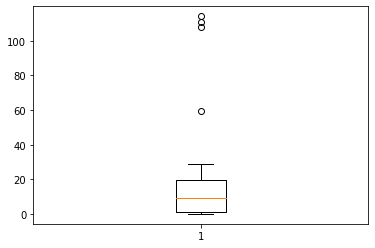

In [267]:
plt.boxplot(sites['elevation_diff'])

### Now adding the earth engine data with probabilities and time frames

Quarters:
* 1: Dec - Feb
* 2: Mar - May
* 3: Jun - Aug
* 4: Sep - Nov

In [280]:
# read in dynamic world probabilities
ee_probs = pd.read_csv("data/ee_new/final_dw_export.csv")

# Merge with Ameriflux
ee_probs = wanted_site_and_info.merge(ee_probs)
ee_probs.head()

,Unnamed: 0,SITE_ID,LULC,LATITUDE,LONGITUDE,ELEVATION,START_DATE,END_DATE,water_mean,trees_mean,grass_mean,flooded_vegetation_mean,crops_mean,shrub_and_scrub_mean,built_mean,bare_mean,snow_and_ice_mean,label_mean,EXTENDED_END_DATE,quarter
0,72,US-Bi1,CRO,38.0992,-121.4993,-2.7,2016-09-01,2016-11-30,0.02761682119,0.05349393774,0.1813774955,0.03307544436,0.5640112722,0.0431392627,0.03946726444,0.02560950331,0.03217092775,4,NaN,2016Q4
1,72,US-Bi1,CRO,38.0992,-121.4993,-2.7,2020-03-02,2020-5-31,0.02844800713,0.107356269,0.2881531931,0.03745729193,0.3839750002,0.04058101464,0.04406316292,0.02708412445,0.04284369071,2.917156863,NaN,2020Q2
2,72,US-Bi1,CRO,38.0992,-121.4993,-2.7,2016-06-01,2016-8-31,0.02868803389,0.04602144912,0.1875522759,0.0355111093,0.5486675974,0.03821819125,0.03506347346,0.04266143754,0.03757841196,3.900082559,NaN,2016Q3
3,72,US-Bi1,CRO,38.0992,-121.4993,-2.7,2019-09-01,2019-11-30,0.02999308292,0.06282355824,0.3364611843,0.0388524813,0.3834155375,0.04046834501,0.04060890486,0.02599412498,0.04134447774,3.187387473,NaN,2019Q4
4,72,US-Bi1,CRO,38.0992,-121.4993,-2.7,2019-06-01,2019-8-31,0.03110266617,0.1050348215,0.2728001487,0.03386274436,0.3781652885,0.04736077644,0.04324800647,0.04608883399,0.04229715499,3.141624355,NaN,2019Q3


In [315]:
# Exporting EE_Probs to CSV
ee_probs.to_csv('data/combined_eda/combined_ee_af_elevation.csv')

In [316]:
### FOR THOSE RUNNING FROM GITHUB --> RUN FROM HERE
ee_probs = pd.read_csv('data/combined_eda/combined_ee_af_elevation.csv')
ee_probs['START_DATE'] = pd.to_datetime(ee_probs['START_DATE'], errors='coerce')
ee_probs['quarter'] = ee_probs['START_DATE'].dt.to_period('Q-NOV')

<AxesSubplot:xlabel='LULC', ylabel='count'>

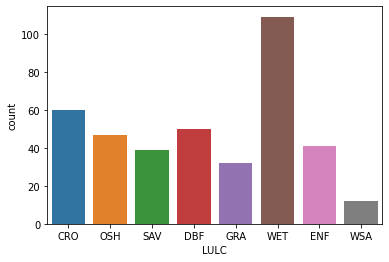

In [317]:
sns.countplot(x="LULC", data=ee_probs)

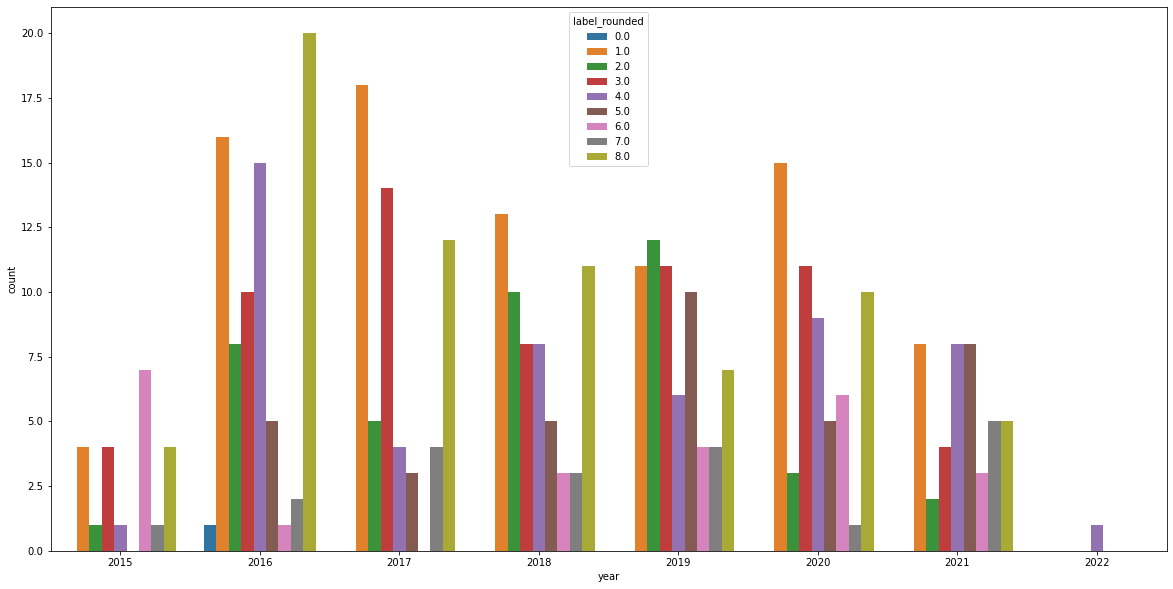

In [318]:
ee_probs['label_mean'] = pd.to_numeric(ee_probs['label_mean'])
ee_probs['year'] = ee_probs['START_DATE'].dt.year
# labels rounded by year
ee_probs['label_rounded'] = ee_probs.label_mean.round()
plt.figure(figsize = (20,10))
p = sns.countplot(x="year", hue="label_rounded", data=ee_probs)

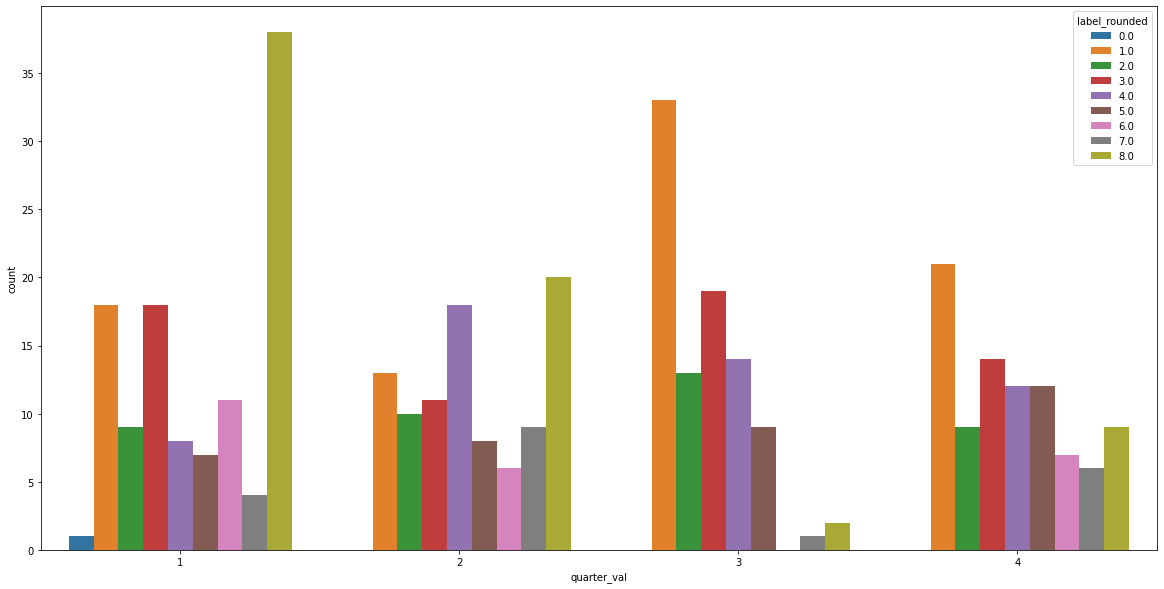

In [319]:
# labels rounded by quarter
ee_probs['quarter_val'] = ee_probs.quarter.dt.quarter
plt.figure(figsize = (20,10))

p = sns.countplot(x="quarter_val", hue="label_rounded", data=ee_probs)

<ipython-input-321-c11b918a4e69>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


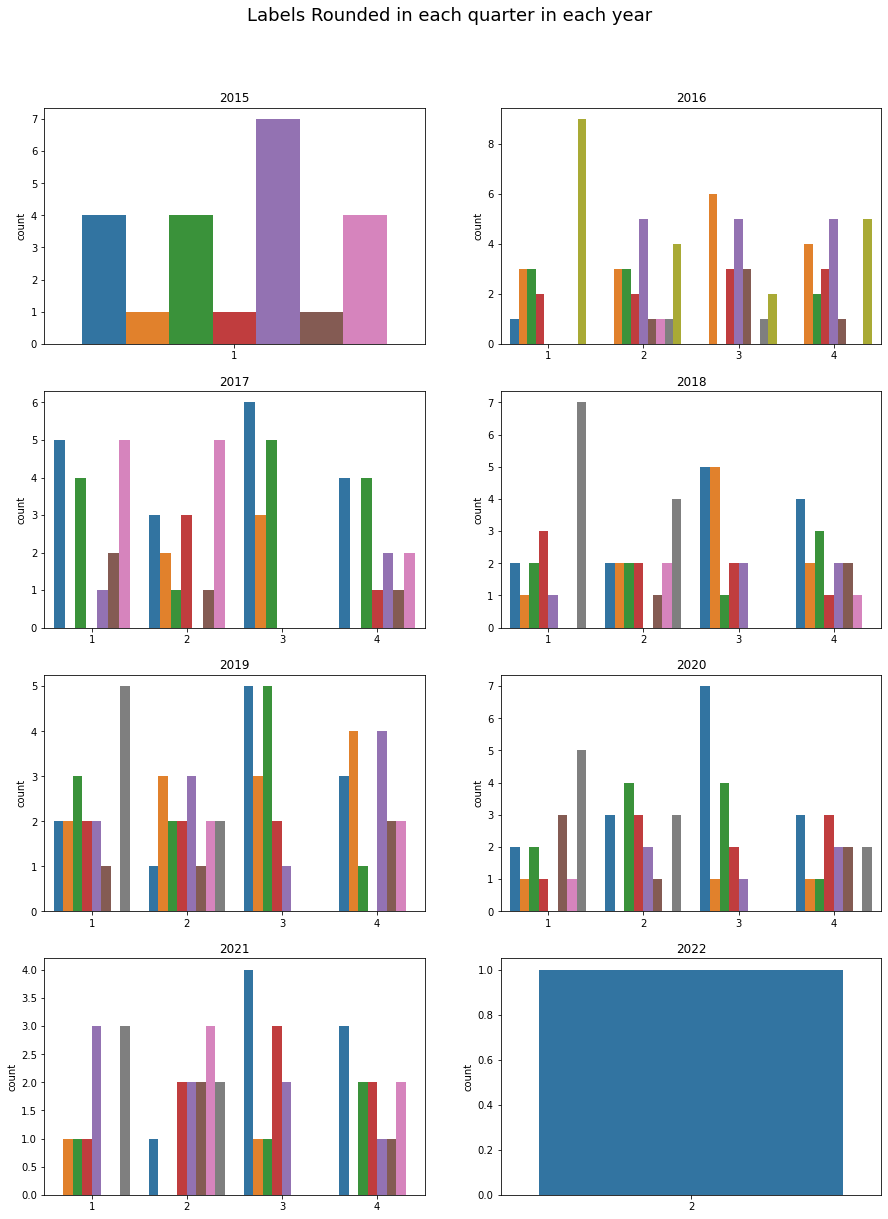

In [321]:
years = ee_probs.year.unique()
years.sort()
# labels rounded by quarter & year
fig, axs = plt.subplots(4, 2, figsize=(15, 20))
fig.suptitle("Labels Rounded in each quarter in each year", fontsize=18, y=0.95)
for y, ax in zip(years, axs.ravel()):
    sns.countplot(x="quarter_val", hue="label_rounded", data=ee_probs[ee_probs['year'] == y], ax=ax)
    ax.set_title(y)
    ax.get_legend().remove()
    ax.set_xlabel("")
    if y == '2016':
        ax.legend(loc='upper left')
fig.show()

In [329]:
ee_mod = pd.read_csv("data/ee_new/final_mod_export.csv")
ee_mod['DATE'] = pd.to_datetime(ee_mod['DATE'], errors='coerce')

# convert to daily
ee_mod = ee_mod.set_index('DATE').groupby('SITE_ID').resample('D').mean().ffill().reset_index()

# add quarterly column
ee_mod['quarter'] = ee_mod['DATE'].dt.to_period('Q-NOV')
ee_mod.head()

,SITE_ID,DATE,Fpar_500m,Lai_500m,quarter
0,US-BZF,2011-01-01,255.0,255.0,2011Q1
1,US-BZF,2011-01-02,255.0,255.0,2011Q1
2,US-BZF,2011-01-03,255.0,255.0,2011Q1
3,US-BZF,2011-01-04,255.0,255.0,2011Q1
4,US-BZF,2011-01-05,255.0,255.0,2011Q1


In [330]:
# code to get first day of the week for ee_mod, as the weeks are irregular
# def get_first_day_of_week(dte):
#     return dte - dt.timedelta(days=dte.isoweekday() % 7) 

# ee_mod['first_day'] = ee_mod['DATE'].apply(get_first_day_of_week)
# ee_mod['week'] = ee_mod['DATE'].dt.to_period('W-SAT').apply(lambda r: r.start_time)-dt.timedelta(days=1)

In [331]:
# read in ee_gridmet
ee_gridmet = pd.read_csv("data/ee_new/final_gridmet_export.csv")
ee_gridmet['DATE'] = pd.to_datetime(ee_gridmet['DATE'], errors='coerce')
ee_gridmet.head()

,system_index,DATE_STR,DATE,SITE_ID,srad,tmmn,tmmx,vpd,.geo
0,00000000000000000030_19980101,19980101,1998-01-02,US-WCr,77.465156,261.014840,271.551632,0.046213,"{""type"":""MultiPoint"",""coordinates"":[]}"
1,00000000000000000030_19980102,19980102,1998-01-03,US-WCr,77.017307,266.355203,274.631221,0.040514,"{""type"":""MultiPoint"",""coordinates"":[]}"
2,00000000000000000030_19980103,19980103,1998-01-04,US-WCr,60.919844,261.384683,271.371212,0.072257,"{""type"":""MultiPoint"",""coordinates"":[]}"
3,00000000000000000030_19980104,19980104,1998-01-05,US-WCr,57.753926,260.144809,268.990932,0.045163,"{""type"":""MultiPoint"",""coordinates"":[]}"
4,00000000000000000030_19980105,19980105,1998-01-06,US-WCr,30.426480,266.905054,272.250911,0.054273,"{""type"":""MultiPoint"",""coordinates"":[]}"


In [332]:
# merge with ee_mod & sites df
merged = ee_gridmet.merge(ee_mod)
combined = sites.merge(merged)
combined.drop(columns=['Unnamed: 0'], inplace=True)
combined.head()

,SITE_ID,LULC,LATITUDE,LONGITUDE,ELEVATION,elevation,elevation_diff,system_index,DATE_STR,DATE,srad,tmmn,tmmx,vpd,.geo,Fpar_500m,Lai_500m,quarter
0,US-Bi1,CRO,38.0992,-121.4993,-2.7,-3.707723,1.007723,00000000000000000003_20160101,20160101,2016-01-02,103.938981,272.867789,282.200012,0.33,"{""type"":""MultiPoint"",""coordinates"":[]}",11.027586,1.416379,2016Q1
1,US-Bi1,CRO,38.0992,-121.4993,-2.7,-3.707723,1.007723,00000000000000000003_20160102,20160102,2016-01-03,39.433899,274.967795,283.100006,0.28,"{""type"":""MultiPoint"",""coordinates"":[]}",11.027586,1.416379,2016Q1
2,US-Bi1,CRO,38.0992,-121.4993,-2.7,-3.707723,1.007723,00000000000000000003_20160103,20160103,2016-01-04,72.405084,274.933894,286.366093,0.18,"{""type"":""MultiPoint"",""coordinates"":[]}",11.027586,1.416379,2016Q1
3,US-Bi1,CRO,38.0992,-121.4993,-2.7,-3.707723,1.007723,00000000000000000003_20160104,20160104,2016-01-05,30.159322,277.767803,286.066106,0.07,"{""type"":""MultiPoint"",""coordinates"":[]}",11.027586,1.416379,2016Q1
4,US-Bi1,CRO,38.0992,-121.4993,-2.7,-3.707723,1.007723,00000000000000000003_20160105,20160105,2016-01-06,63.735592,281.100006,285.833888,0.25,"{""type"":""MultiPoint"",""coordinates"":[]}",11.027586,1.416379,2016Q1


In [327]:
# Exporting combined to CSV
combined.to_csv('data/combined_eda/combined.csv')

In [328]:
### FOR THOSE RUNNING FROM GITHUB --> RUN FROM HERE
combined = pd.read_csv('data/combined_eda/combined.csv')

# Exploratory Data Analysis (EDA)

Exploring the combined AmeriFlux & EE data

Regarding Label, the values for land classes in the dynamic world dataset are defined [here](https://developers.google.com/earth-engine/datasets/catalog/GOOGLE_DYNAMICWORLD_V1#bands)

| Value | Description        |
|-------|--------------------|
| 0     | water              |
| 1     | trees              |
| 2     | grass              |
| 3     | flooded_vegetation |
| 4     | crops              |
| 5     | shrub_and_scrub    |
| 6     | built              |
| 7     | bare               |
| 8     | snow_and_ice       |

LULC Labels from AmeriFlux ([link](https://fluxnet.org/data/badm-data-templates/igbp-classification/)):

| label | name                                | description                                                                                                                                                                                                                                         |
|-------|-------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| BSV   | Barren Sparse Vegetation            | Lands exposed soil, sand, or rocks and has less than 10% vegetative cover during any time of the year.                                                                                                                                              |
| CRO   | Croplands                           | Lands covered with temporary crops followed by harvest and a bare soil period (e.g., single and multiple cropping systems). Note that perennial woody crops will be classified as the appropriate forest or shrub land cover type.                  |
| CSH   | Closed Shrublands                   | Lands with woody vegetation less than 2 meters tall and with shrub canopy cover >60%. The shrub foliage can be either evergreen or deciduous.                                                                                                       |
| CVM   | Cropland/Natural Vegetation Mosaics | Lands with a mosaic of croplands, forest, shrublands, and grasslands in which no one component comprises more than 60% of the landscape.                                                                                                            |
| DBF   | Deciduous Broadleaf Forests         | Lands dominated by woody vegetation with a percent cover >60% and height exceeding 2 meters. Consists of broadleaf tree communities with an annual cycle of leaf-on and leaf-off periods.                                                           |
| DNF   | Deciduous Needleleaf Forests        | Lands dominated by woody vegetation with a percent cover >60% and height exceeding 2 meters. Consists of seasonal needleleaf tree communities with an annual cycle of leaf-on and leaf-off periods.                                                 |
| EBF   | Evergreen Broadleaf Forests         | Lands dominated by woody vegetation with a percent cover >60% and height exceeding 2 meters. Almost all trees and shrubs remain green year round. Canopy is never without green foliage.                                                            |
| ENF   | Evergreen Needleleaf Forests        | Lands dominated by woody vegetation with a percent cover >60% and height exceeding 2 meters. Almost all trees remain green all year. Canopy is never without green foliage.                                                                         |
| GRA   | Grasslands                          | Lands with herbaceous types of cover. Tree and shrub cover is less than 10%. Permanent wetlands lands with a permanent mixture of water and herbaceous or woody vegetation. The vegetation can be present in either salt, brackish, or fresh water. |
| MF    | Mixed Forests                       | Lands dominated by trees with a percent cover >60% and height exceeding 2 meters. Consists of tree communities with interspersed mixtures or mosaics of the other four forest types. None of the forest types exceeds 60% of landscape.             |
| OSH   | Open Shrublands                     | Lands with woody vegetation less than 2 meters tall and with shrub canopy cover between 10-60%. The shrub foliage can be either evergreen or deciduous.                                                                                             |
| SAV   | Savannas                            | Lands with herbaceous and other understory systems, and with forest canopy cover between 10-30%. The forest cover height exceeds 2 meters.                                                                                                          |
| SNO   | Snow and Ice                        | Lands under snow/ice cover most of the year.                                                                                                                                                                                                        |
| URB   | Urban and Built-Up Lands            | Land covered by buildings and other man-made structures.                                                                                                                                                                                            |
| WAT   | Water Bodies                        |                                                                                                                                                                                                                                                     |
| WET   | Permanent Wetland                   | Lands with a permanent mixture of water and herbaceous or woody vegetation that cover extensive areas. The vegetation can be present in either salt, brackish, or fresh water.                                                                      |
| WSA   | Woody Savannas                      | Lands with herbaceous and other understory systems, and with forest canopy cover between 30-60%. The forest cover height exceeds 2 meters.                                                                                                          |

In [333]:
combined.head()

,SITE_ID,LULC,LATITUDE,LONGITUDE,ELEVATION,elevation,elevation_diff,system_index,DATE_STR,DATE,srad,tmmn,tmmx,vpd,.geo,Fpar_500m,Lai_500m,quarter
0,US-Bi1,CRO,38.0992,-121.4993,-2.7,-3.707723,1.007723,00000000000000000003_20160101,20160101,2016-01-02,103.938981,272.867789,282.200012,0.33,"{""type"":""MultiPoint"",""coordinates"":[]}",11.027586,1.416379,2016Q1
1,US-Bi1,CRO,38.0992,-121.4993,-2.7,-3.707723,1.007723,00000000000000000003_20160102,20160102,2016-01-03,39.433899,274.967795,283.100006,0.28,"{""type"":""MultiPoint"",""coordinates"":[]}",11.027586,1.416379,2016Q1
2,US-Bi1,CRO,38.0992,-121.4993,-2.7,-3.707723,1.007723,00000000000000000003_20160103,20160103,2016-01-04,72.405084,274.933894,286.366093,0.18,"{""type"":""MultiPoint"",""coordinates"":[]}",11.027586,1.416379,2016Q1
3,US-Bi1,CRO,38.0992,-121.4993,-2.7,-3.707723,1.007723,00000000000000000003_20160104,20160104,2016-01-05,30.159322,277.767803,286.066106,0.07,"{""type"":""MultiPoint"",""coordinates"":[]}",11.027586,1.416379,2016Q1
4,US-Bi1,CRO,38.0992,-121.4993,-2.7,-3.707723,1.007723,00000000000000000003_20160105,20160105,2016-01-06,63.735592,281.100006,285.833888,0.25,"{""type"":""MultiPoint"",""coordinates"":[]}",11.027586,1.416379,2016Q1


----------
----------
----------

# Previous Code - Ignore for now
----------


In [103]:
# Filter to get only the necessary sites
potential_sites_file = open('data/potential_sites.json')
potential_sites_dict = json.load(potential_sites_file)
potential_site_names = list(potential_sites_dict.keys())

all_sites_df = pd.read_csv("data/ameriflux_lulc_lat_long.csv")

wanted_site_and_info = all_sites_df[all_sites_df['SITE_ID'].isin(potential_site_names)]
wanted_site_and_info.to_csv('data/wanted_sites.csv')

(array([19.,  8.,  2.,  0.,  0.,  1.,  0.,  0.,  0.,  3.]),
 array([5.65676503e-02, 1.14686216e+01, 2.28806756e+01, 3.42927296e+01,
        4.57047836e+01, 5.71168375e+01, 6.85288915e+01, 7.99409455e+01,
        9.13529995e+01, 1.02765053e+02, 1.14177107e+02]),
 <BarContainer object of 10 artists>)

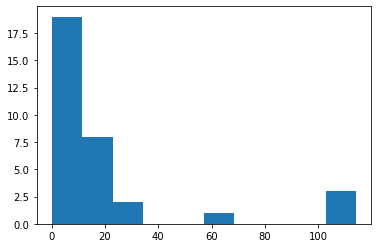

In [104]:
# Combine with earth engine's elevation data ("elevation_for_towers_in_us_10m.csv") and get difference in elevations

ee_elevation = pd.read_csv("data/elevation_for_towers_in_us_10m.csv")
sites = wanted_site_and_info.merge(ee_elevation)
sites['elevation_diff'] = abs(sites['ELEVATION'] - sites['elevation'])

# Histogram of elevation difference at a given site between AF and EE data
plt.hist(sites['elevation_diff'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f97b3a46a50>,
 'caps': [<matplotlib.lines.Line2D at 0x7f97b3e0af50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f97b3a46150>],
 'medians': [<matplotlib.lines.Line2D at 0x7f97b3873a10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f97b3873610>],
 'means': []}

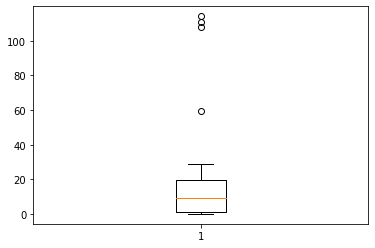

In [105]:
plt.boxplot(sites['elevation_diff'])

### Now adding the earth engine data with probabilities and time frames

timeframes/quarters:
* 1: Jan - Feb
* 2: Mar - May
* 3: Jun - Sep
* 4: Oct - Dec

(intervals are not equal)

In [149]:
# Get list of all files
path_to_ee_files = "data/earthengine_raw"
files = [f for f in listdir(path_to_ee_files) if isfile(join(path_to_ee_files, f))]

def get_quarter(q_str):
    if q_str == 'jan':
        return 1
    elif q_str == 'mar':
        return 2
    elif q_str == 'jun':
        return 3
    elif q_str == 'oct':
        return 4
    else:
        return None

# Get Site IDS
site_ids_df = pd.read_excel(path_to_ee_files + '/DW_MEAN_2016_mar_to_may.xlsx')
site_ids_df = site_ids_df[['.geo', 'SITE_ID']]

# Combine ee dfs
ee_dfs = []
for f in files:
    try:
        ee_df = pd.read_csv(path_to_ee_files + '/' + f)
    except:
        ee_df = pd.read_excel(path_to_ee_files + '/' + f)
    splt_str = re.split("[._]+", f)
    ee_df['year'] = splt_str[2]
    ee_df['quarter'] = get_quarter(splt_str[3])
    if 'SITE_ID' not in ee_df:
        ee_df = ee_df.merge(site_ids_df, on='.geo')
    print(f)
#     print(ee_df.head())
    print(ee_df.columns)
    ee_dfs.append(ee_df)
# Combine all Dynamic World Datasets
combined_ee = pd.concat(ee_dfs)
combined_ee.drop(columns=['Unnamed: 12', 'Unnamed: 13','Unnamed: 14', 'Unnamed: 15'], inplace=True)
combined_ee.drop_duplicates(subset=list(combined_ee.columns[11:]), inplace=True)

# Merge with Ameriflux
combined = wanted_site_and_info.merge(combined_ee)

DW_MEAN_2016_jun_to_sep.csv
Index(['system:index', 'bare_mean', 'built_mean', 'crops_mean',
       'flooded_vegetation_mean', 'grass_mean', 'label_mean',
       'shrub_and_scrub_mean', 'snow_and_ice_mean', 'trees_mean', 'water_mean',
       '.geo', 'year', 'quarter', 'SITE_ID'],
      dtype='object')
DW_MEAN_2016_jan_to_feb.csv
Index(['system:index', '.geo', 'year', 'quarter', 'SITE_ID'], dtype='object')
DW_MEAN_2019_jan_to_feb.csv
Index(['system:index', 'bare_mean', 'built_mean', 'crops_mean',
       'flooded_vegetation_mean', 'grass_mean', 'label_mean',
       'shrub_and_scrub_mean', 'snow_and_ice_mean', 'trees_mean', 'water_mean',
       '.geo', 'year', 'quarter', 'SITE_ID'],
      dtype='object')
DW_MEAN_2021_mar_to_may.csv
Index(['system:index', 'bare_mean', 'built_mean', 'crops_mean',
       'flooded_vegetation_mean', 'grass_mean', 'label_mean',
       'shrub_and_scrub_mean', 'snow_and_ice_mean', 'trees_mean', 'water_mean',
       '.geo', 'year', 'quarter', 'SITE_ID'],
      dtyp

In [150]:
combined.columns

Index(['Unnamed: 0', 'SITE_ID', 'LULC', 'LATITUDE', 'LONGITUDE', 'ELEVATION',
       'system:index', 'bare_mean', 'built_mean', 'crops_mean',
       'flooded_vegetation_mean', 'grass_mean', 'label_mean',
       'shrub_and_scrub_mean', 'snow_and_ice_mean', 'trees_mean', 'water_mean',
       '.geo', 'year', 'quarter'],
      dtype='object')

In [151]:
combined.head()

,Unnamed: 0,SITE_ID,LULC,LATITUDE,LONGITUDE,ELEVATION,system:index,bare_mean,built_mean,crops_mean,flooded_vegetation_mean,grass_mean,label_mean,shrub_and_scrub_mean,snow_and_ice_mean,trees_mean,water_mean,.geo,year,quarter
0,72,US-Bi1,CRO,38.0992,-121.4993,-2.7,00000000000000000000,0.037068,0.035150,0.553335,0.035180,0.184960,3.969476,0.037079,0.036268,0.052907,0.028016,"{""type"":""Point"",""coordinates"":[-121.4992980957...",2016,3
1,72,US-Bi1,CRO,38.0992,-121.4993,-2.7,00000000000000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""type"":""Point"",""coordinates"":[-121.4992980957...",2016,1
2,72,US-Bi1,CRO,38.0992,-121.4993,-2.7,00000000000000000000,0.066526,0.031412,0.124313,0.033364,0.290362,1.566305,0.141127,0.043382,0.232148,0.037324,"{""type"":""Point"",""coordinates"":[-121.4992980957...",2019,1
3,72,US-Bi1,CRO,38.0992,-121.4993,-2.7,00000000000000000000,0.028153,0.038775,0.473804,0.037220,0.266575,3.500000,0.035955,0.046292,0.040924,0.032265,"{""type"":""Point"",""coordinates"":[-121.4992980957...",2021,2
4,72,US-Bi1,CRO,38.0992,-121.4993,-2.7,00000000000000000000,0.042523,0.044088,0.394532,0.036490,0.261713,3.310361,0.043507,0.043159,0.104685,0.029264,"{""type"":""Point"",""coordinates"":[-121.4992980957...",2019,3


# Exploratory Data Analysis (EDA)

Exploring the combined AmeriFlux & EE data

Regarding Label, the values for land classes in the dynamic world dataset are defined [here](https://developers.google.com/earth-engine/datasets/catalog/GOOGLE_DYNAMICWORLD_V1#bands)

| Value | Description        |
|-------|--------------------|
| 0     | water              |
| 1     | trees              |
| 2     | grass              |
| 3     | flooded_vegetation |
| 4     | crops              |
| 5     | shrub_and_scrub    |
| 6     | built              |
| 7     | bare               |
| 8     | snow_and_ice       |

LULC Labels from AmeriFlux ([link](https://fluxnet.org/data/badm-data-templates/igbp-classification/)):

| label | name                                | description                                                                                                                                                                                                                                         |
|-------|-------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| BSV   | Barren Sparse Vegetation            | Lands exposed soil, sand, or rocks and has less than 10% vegetative cover during any time of the year.                                                                                                                                              |
| CRO   | Croplands                           | Lands covered with temporary crops followed by harvest and a bare soil period (e.g., single and multiple cropping systems). Note that perennial woody crops will be classified as the appropriate forest or shrub land cover type.                  |
| CSH   | Closed Shrublands                   | Lands with woody vegetation less than 2 meters tall and with shrub canopy cover >60%. The shrub foliage can be either evergreen or deciduous.                                                                                                       |
| CVM   | Cropland/Natural Vegetation Mosaics | Lands with a mosaic of croplands, forest, shrublands, and grasslands in which no one component comprises more than 60% of the landscape.                                                                                                            |
| DBF   | Deciduous Broadleaf Forests         | Lands dominated by woody vegetation with a percent cover >60% and height exceeding 2 meters. Consists of broadleaf tree communities with an annual cycle of leaf-on and leaf-off periods.                                                           |
| DNF   | Deciduous Needleleaf Forests        | Lands dominated by woody vegetation with a percent cover >60% and height exceeding 2 meters. Consists of seasonal needleleaf tree communities with an annual cycle of leaf-on and leaf-off periods.                                                 |
| EBF   | Evergreen Broadleaf Forests         | Lands dominated by woody vegetation with a percent cover >60% and height exceeding 2 meters. Almost all trees and shrubs remain green year round. Canopy is never without green foliage.                                                            |
| ENF   | Evergreen Needleleaf Forests        | Lands dominated by woody vegetation with a percent cover >60% and height exceeding 2 meters. Almost all trees remain green all year. Canopy is never without green foliage.                                                                         |
| GRA   | Grasslands                          | Lands with herbaceous types of cover. Tree and shrub cover is less than 10%. Permanent wetlands lands with a permanent mixture of water and herbaceous or woody vegetation. The vegetation can be present in either salt, brackish, or fresh water. |
| MF    | Mixed Forests                       | Lands dominated by trees with a percent cover >60% and height exceeding 2 meters. Consists of tree communities with interspersed mixtures or mosaics of the other four forest types. None of the forest types exceeds 60% of landscape.             |
| OSH   | Open Shrublands                     | Lands with woody vegetation less than 2 meters tall and with shrub canopy cover between 10-60%. The shrub foliage can be either evergreen or deciduous.                                                                                             |
| SAV   | Savannas                            | Lands with herbaceous and other understory systems, and with forest canopy cover between 10-30%. The forest cover height exceeds 2 meters.                                                                                                          |
| SNO   | Snow and Ice                        | Lands under snow/ice cover most of the year.                                                                                                                                                                                                        |
| URB   | Urban and Built-Up Lands            | Land covered by buildings and other man-made structures.                                                                                                                                                                                            |
| WAT   | Water Bodies                        |                                                                                                                                                                                                                                                     |
| WET   | Permanent Wetland                   | Lands with a permanent mixture of water and herbaceous or woody vegetation that cover extensive areas. The vegetation can be present in either salt, brackish, or fresh water.                                                                      |
| WSA   | Woody Savannas                      | Lands with herbaceous and other understory systems, and with forest canopy cover between 30-60%. The forest cover height exceeds 2 meters.                                                                                                          |

In [268]:
# Create Date column combining year and quarter
combined['date'] = combined.year + 'Q' + combined.quarter.astype(str)
combined['date'] = pd.PeriodIndex(combined['date'], freq='Q')
combined['date'] = combined.date.astype('str')

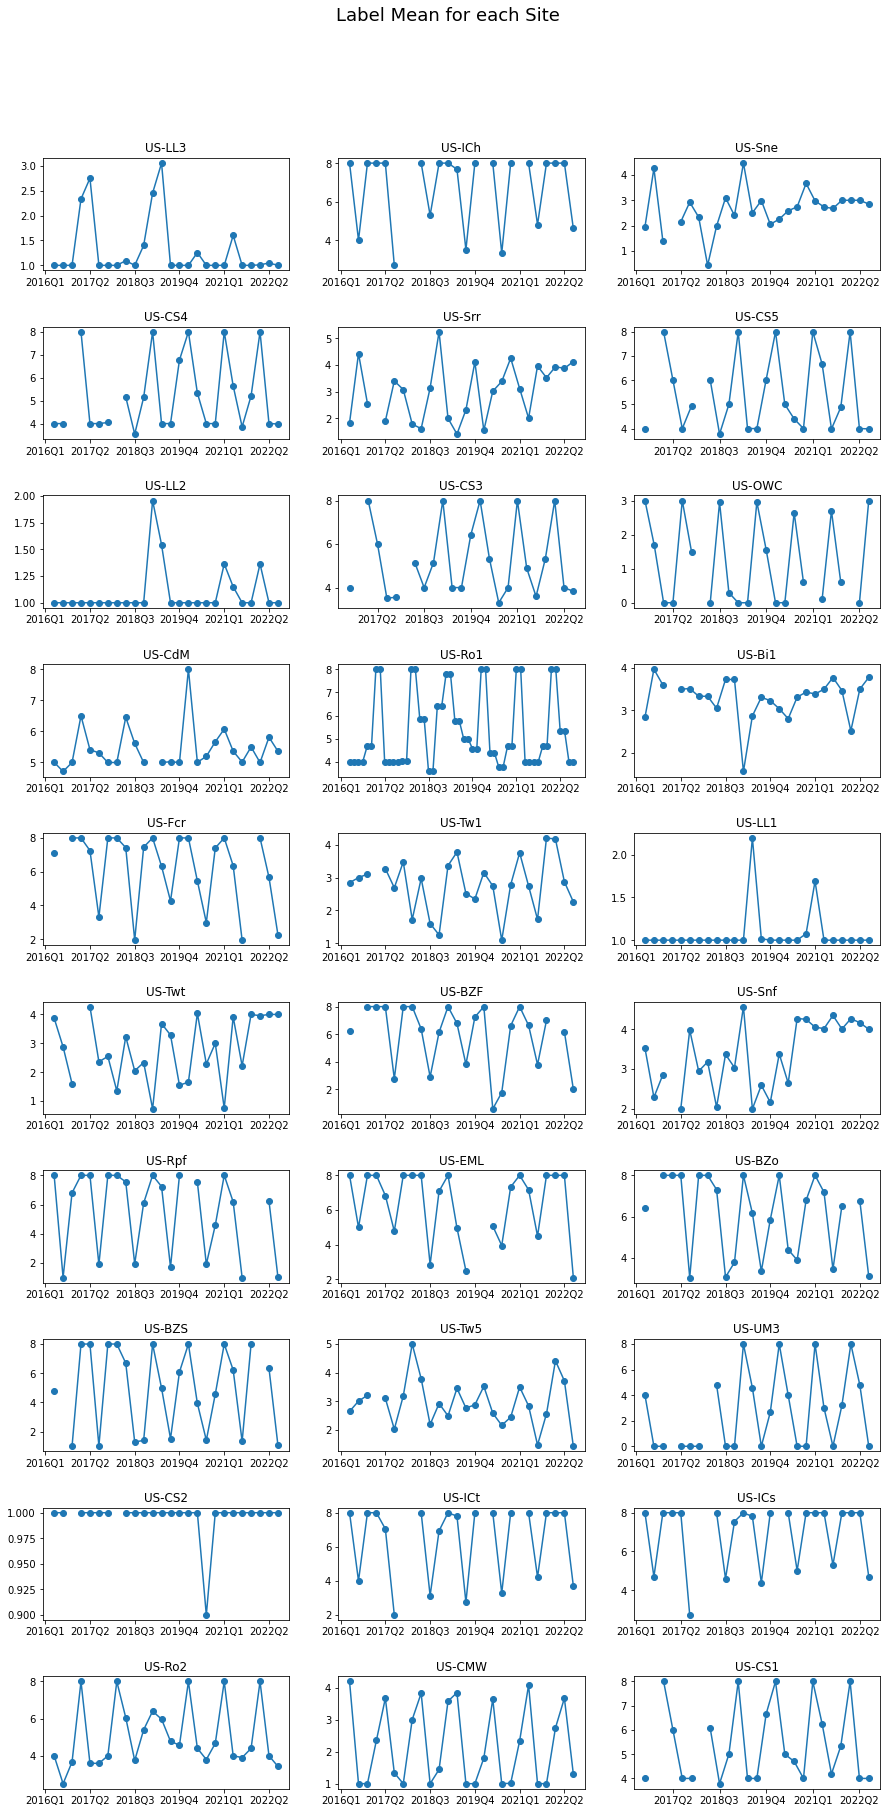

In [281]:
# define subplot grid
fig, axs = plt.subplots(nrows=10, ncols=3, figsize=(15, 30))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Label Mean for each Site", fontsize=18, y=0.95)

# loop through sites and axes
for site, ax in zip(sites, axs.ravel()):
    # filter df for ticker and plot on specified axes
    temp = combined[combined['SITE_ID'] == site]
    temp = temp.sort_values('date')
    temp.plot('date', 'label_mean', ax=ax, marker="o")

    # chart formatting
    ax.set_title(site)
    ax.get_legend().remove()
    ax.set_xlabel("")

plt.show()

In [270]:
sites

array(['US-LL3', 'US-ICh', 'US-Sne', 'US-CS4', 'US-Srr', 'US-CS5',
       'US-LL2', 'US-CS3', 'US-OWC', 'US-CdM', 'US-Ro1', 'US-Bi1',
       'US-Fcr', 'US-Tw1', 'US-LL1', 'US-Twt', 'US-BZF', 'US-Snf',
       'US-Rpf', 'US-EML', 'US-BZo', 'US-BZS', 'US-Tw5', 'US-UM3',
       'US-CS2', 'US-ICt', 'US-ICs', 'US-Ro2', 'US-CMW', 'US-CS1'],
      dtype=object)

In [282]:
# filter by sites of interest
sites_of_interest = ['US-Ro2', 'US-ICs', 'US-BZF']
combined_interested = combined[combined['SITE_ID'].isin(sites_of_interest)]
combined_interested.head()

,Unnamed: 0,SITE_ID,LULC,LATITUDE,LONGITUDE,ELEVATION,system:index,bare_mean,built_mean,crops_mean,...,grass_mean,label_mean,shrub_and_scrub_mean,snow_and_ice_mean,trees_mean,water_mean,.geo,year,quarter,date
28,81,US-BZF,WET,64.7013,-148.3121,95.0,00000000000000000002,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"{""type"":""Point"",""coordinates"":[-148.3121032714...",2016,1,2016Q1
379,149,US-ICs,WET,68.6058,-149.3110,920.0,0000000000000000000f,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"{""type"":""Point"",""coordinates"":[-149.3110046386...",2016,1,2016Q1
595,272,US-Ro2,CRO,44.7288,-93.0888,292.0,00000000000000000025,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"{""type"":""Point"",""coordinates"":[-93.08879852294...",2016,1,2016Q1
395,149,US-ICs,WET,68.6058,-149.3110,920.0,0000000000000000000f,0.108170,0.033424,0.031261,...,0.032421,8.0,0.019385,0.667091,0.027831,0.048588,"{""type"":""Point"",""coordinates"":[-149.3110046386...",2016,2,2016Q2
611,272,US-Ro2,CRO,44.7288,-93.0888,292.0,25.0,0.025858,0.037891,0.412532,...,0.347921,4.0,0.027195,0.037293,0.034927,0.030197,"{""type"":""Point"",""coordinates"":[-93.08879852294...",2016,2,2016Q2


In [284]:
combined_interested[combined_interested['SITE_ID'] == 'US-BZF'].label_mean

28         NaN
44    6.233494
27         NaN
47    8.000000
37    8.000000
45    8.000000
38    2.759399
46    8.000000
35    8.000000
43    6.381804
34    2.893452
40    6.136820
29    8.000000
49    6.773857
31    3.806186
51    7.240412
42    8.000000
36    0.567997
41    1.750000
33    6.613597
48    8.000000
30    6.636364
50    3.782885
32    7.000000
53         NaN
39    6.166916
52    2.000044
Name: label_mean, dtype: float64

Observe land classes in AmeriFlux and Dynamic World

<AxesSubplot:xlabel='LULC', ylabel='count'>

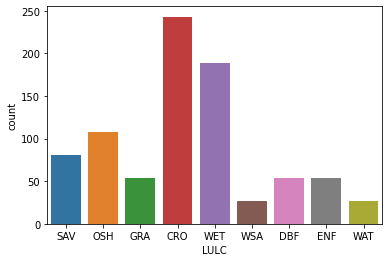

In [300]:
sns.countplot(x="LULC", data=combined)

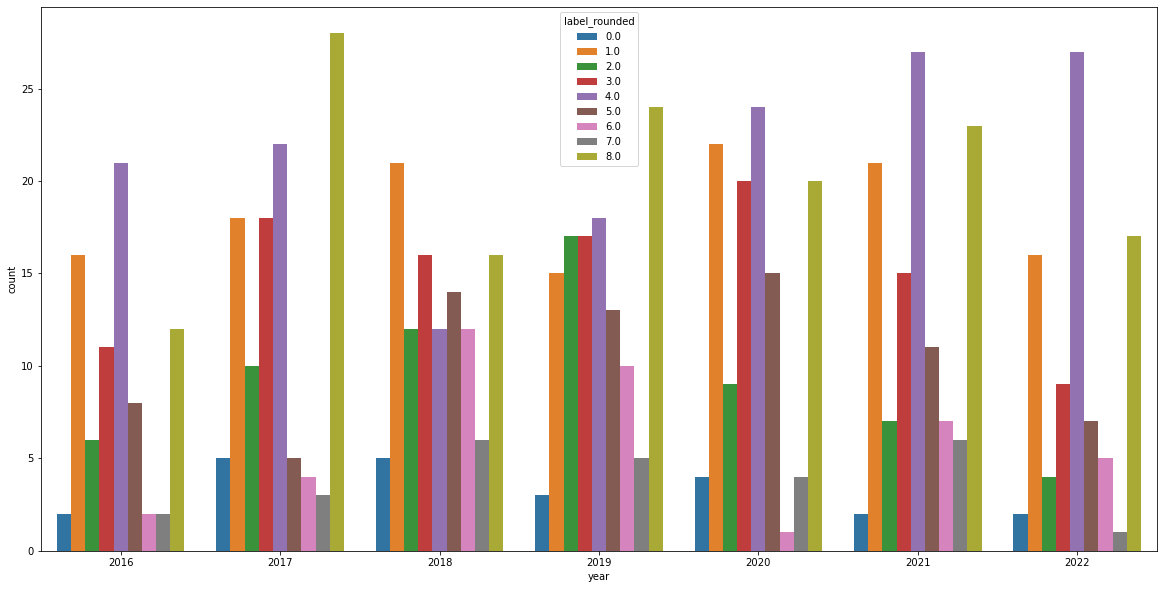

In [312]:
# labels rounded by year
combined['label_rounded'] = combined.label_mean.round()
plt.figure(figsize = (20,10))
p = sns.countplot(x="year", hue="label_rounded", data=combined)

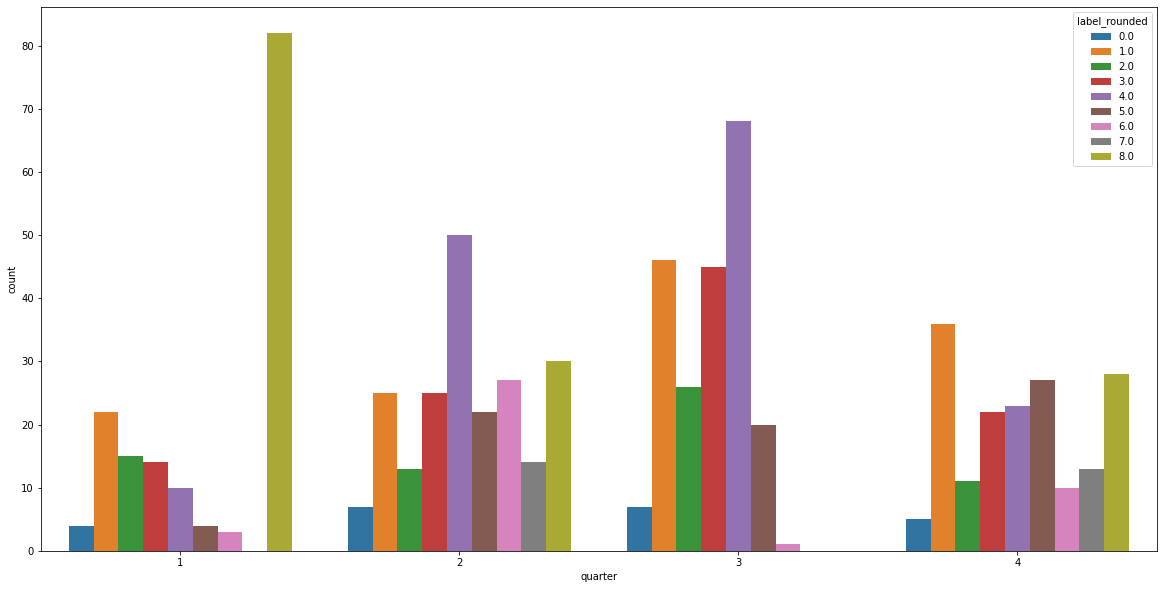

In [313]:
# labels rounded by quarter
combined['label_rounded'] = combined.label_mean.round()
plt.figure(figsize = (20,10))
p = sns.countplot(x="quarter", hue="label_rounded", data=combined)

/Users/charagon/opt/anaconda3/envs/w281/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


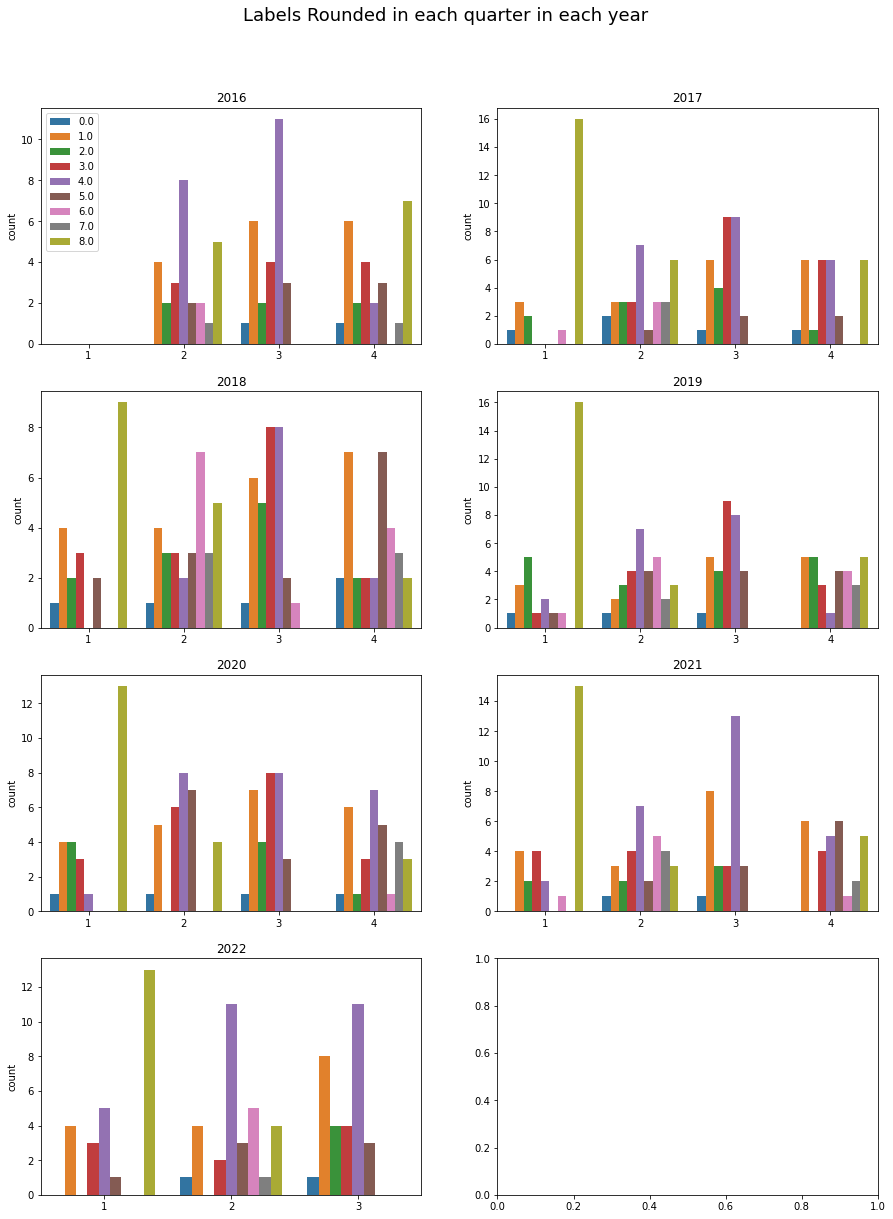

In [343]:
years = combined.year.unique()

# labels rounded by quarter & year
fig, axs = plt.subplots(4, 2, figsize=(15, 20))
fig.suptitle("Labels Rounded in each quarter in each year", fontsize=18, y=0.95)
for y, ax in zip(years, axs.ravel()):
    sns.countplot(x="quarter", hue="label_rounded", data=combined[combined['year'] == y], ax=ax)
    ax.set_title(y)
    ax.get_legend().remove()
    ax.set_xlabel("")
    if y == '2016':
        ax.legend(loc='upper left')
fig.show()